In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import pywt
from scipy.fftpack import fft, rfft
from pymssa import MSSA


matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

/root/miniconda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data loading

In [2]:
chaos = pd.read_csv('./chaos_sample_5.txt', delimiter='\t')
timestamps = np.array(chaos.index)

In [3]:
chaos.head()

,5001,5002,5003,5004,5005,5006,5007,5008,5009,5010,...,5356,5357,5358,5359,5360,5361,5362,5363,5364,5365
90000.0,-0.000018,-0.001784,-0.917791,4.408553,-0.421157,-0.001683,-0.001692,-35.029201,-0.898255,2.201222,...,-0.000024,-0.000349,-0.000304,-0.000090,-0.000115,-0.000312,-0.000345,-0.000689,-0.000311,-0.000064
90018.0,0.000027,-1.190258,-0.914819,5.881844,-2.097727,-4.178118,-5.418659,-48.139564,-4.477319,1.323359,...,0.000036,0.000515,0.000449,0.000133,0.000170,0.000461,0.000509,0.001016,0.000459,0.000095
90036.0,-0.000092,1.184401,0.910830,7.343917,-0.005728,-1.401305,-2.040379,-52.529410,-1.801491,2.196292,...,-0.000123,-0.001773,-0.001544,-0.000458,-0.000586,-0.001587,-0.001750,-0.003498,-0.001578,-0.000327
90054.0,-0.000174,1.176377,4.573808,7.338222,-0.011130,3.472234,2.699381,-26.249873,-3.602408,5.275150,...,-0.000232,-0.003344,-0.002912,-0.000864,-0.001105,-0.002992,-0.003300,-0.006596,-0.002976,-0.000617
90074.0,-0.000287,1.165260,7.318367,8.800920,2.081696,6.251727,3.367077,-26.268146,-0.029089,8.352831,...,-0.000383,-0.005520,-0.004807,-0.001426,-0.001825,-0.004939,-0.005448,-0.010888,-0.004913,-0.001019


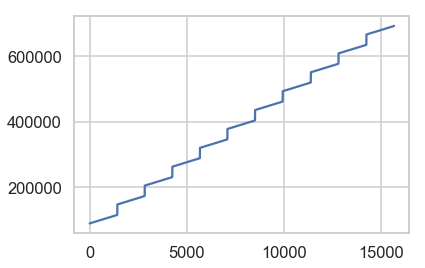

In [4]:
plt.plot(timestamps)

## Preprocessing

  1. Divide samples according to 
  2. Resample it with 18 sec intervals
  3. Smoothing with `savgol_filter`(not interested in high frequencies __for now__)

In [5]:
from scipy.signal import savgol_filter
from scipy import interpolate

In [6]:
X_divided = []
timestamps_divided = []

t_prev = 0
argdiff = np.argwhere(np.diff(timestamps) > 100).ravel()
for t_next in argdiff[:-1][np.diff(argdiff) > 100]:
    if t_next - t_prev < 20:
        t_prev = t_next
        continue
    print(t_next - t_prev)
    X_selected = chaos.values[t_prev + 1:t_next, :]
    timestamps_selected = timestamps[t_prev + 1: t_next]
    f = interpolate.interp1d(timestamps_selected, X_selected, axis=0)
    ts_resampled = np.arange(timestamps_selected.min(), timestamps_selected.max(), 18.)
    X_resampled = f(ts_resampled)
    timestamps_divided.append(ts_resampled)
    X_divided.append(savgol_filter(X_resampled, window_length=21, polyorder=3, axis=0))
    t_prev = t_next

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


1421
1410
1421
1422
1415
1422
1425
1447
1425
1435


Check that everything is OK

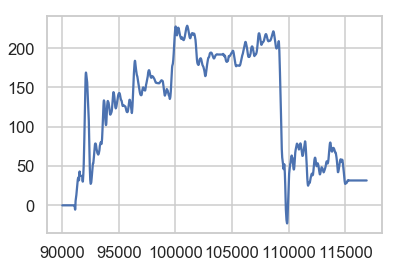

In [7]:
plt.plot(timestamps_divided[0], X_divided[0][:, 0])

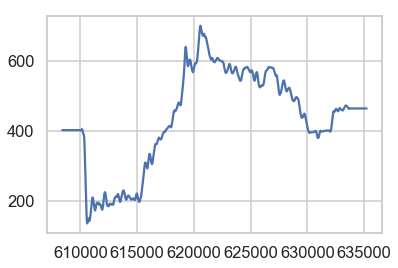

In [8]:
plt.plot(timestamps_divided[-1], X_divided[-1][:, 0])

## MSSA

https://arxiv.org/pdf/1308.4022.pdf

https://github.com/kieferk/pymssa

Применим MSSA к анализу первого кластера.

MSSA строит эмпирический базис.

In [9]:
d = 0
X = X_divided[d]
timestamps = timestamps_divided[d]

In [10]:
X.shape

(1493, 365)

In [11]:
def std_norm(x, axis=-1):
    return (x - x.mean(axis=axis, keepdims=True)) / x.std(axis=axis, keepdims=True)

In [12]:
%%time
mssa = MSSA(window_size=30, n_components=30).fit(std_norm(X, axis=0))

Constructing trajectory matrix
Trajectory matrix shape: (10950, 1464)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
CPU times: user 11min 14s, sys: 10min 8s, total: 21min 23s
Wall time: 1min 35s


## Рассмотрим для примера 2 time-series

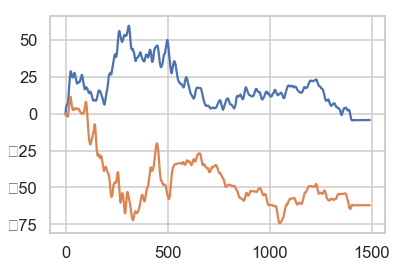

In [13]:
plt.plot(X[:, 2])
plt.plot(X[:, 4])

Отсортированные по важности(количество объяснённой дисперсии) собственные компоненты.

In [14]:
mssa.component_ranks_[:5, [2, 4]]

array([[2, 0],
       [0, 2],
       [4, 3],
       [1, 5],
       [9, 4]])

In [15]:
mssa.component_ranks_explained_variance_[:5, [2, 4]]

array([[0.14497069, 0.51677295],
       [0.26277735, 0.1947945 ],
       [0.23627534, 0.14285763],
       [0.21966608, 0.03406295],
       [0.01927076, 0.00365514]])

### Визуализация собственных компонент для тайм-серии 2

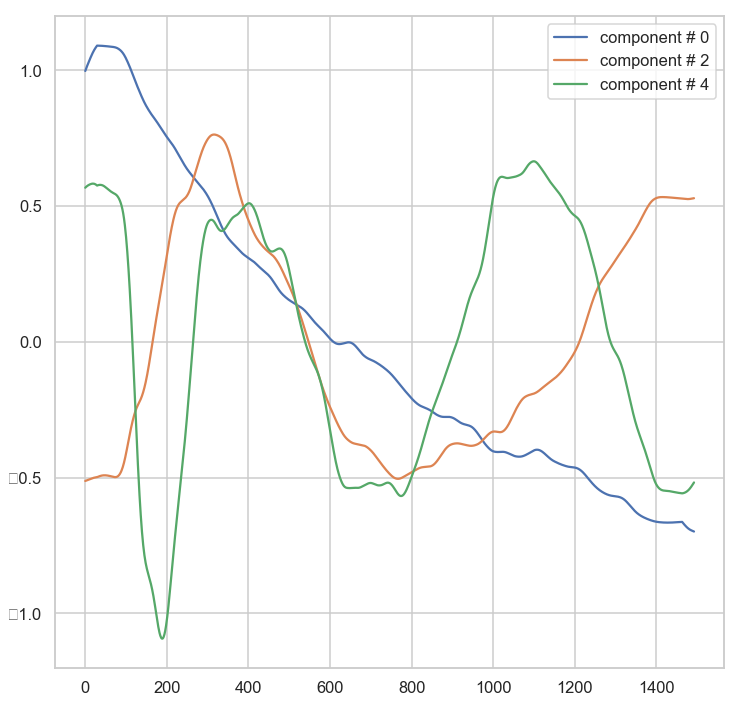

In [16]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[2, :, 0], label='component # 0')
plt.plot(mssa.components_[2, :, 2], label='component # 2')
plt.plot(mssa.components_[2, :, 4], label='component # 4')
plt.legend()
plt.show()

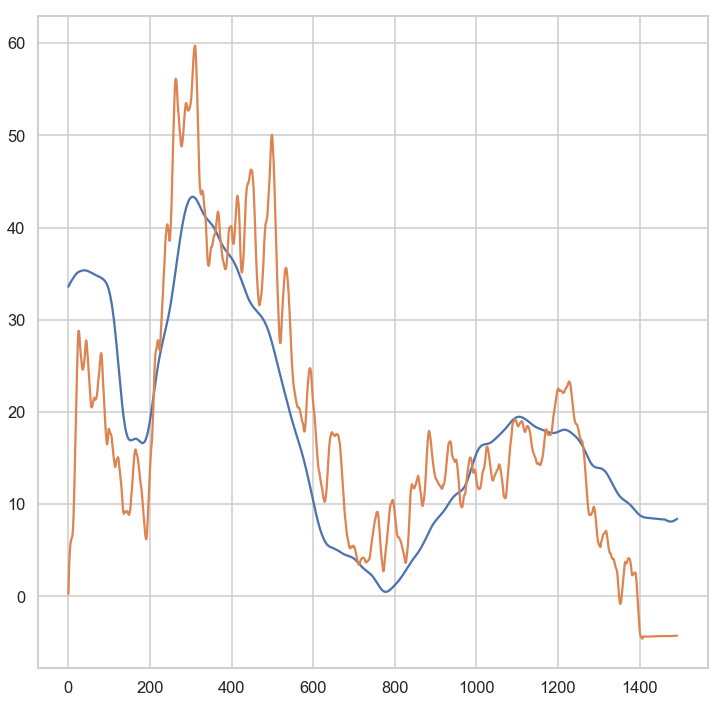

In [17]:
plt.figure(figsize=(12, 12))
plt.plot((mssa.components_[2, :, 0] + mssa.components_[2, :, 2] + mssa.components_[2, :, 4]) * X[:, 2].std() + X[:, 2].mean())
plt.plot(X[:, 2])
plt.show()

### Визуализация собственных компонент для тайм-серии 4

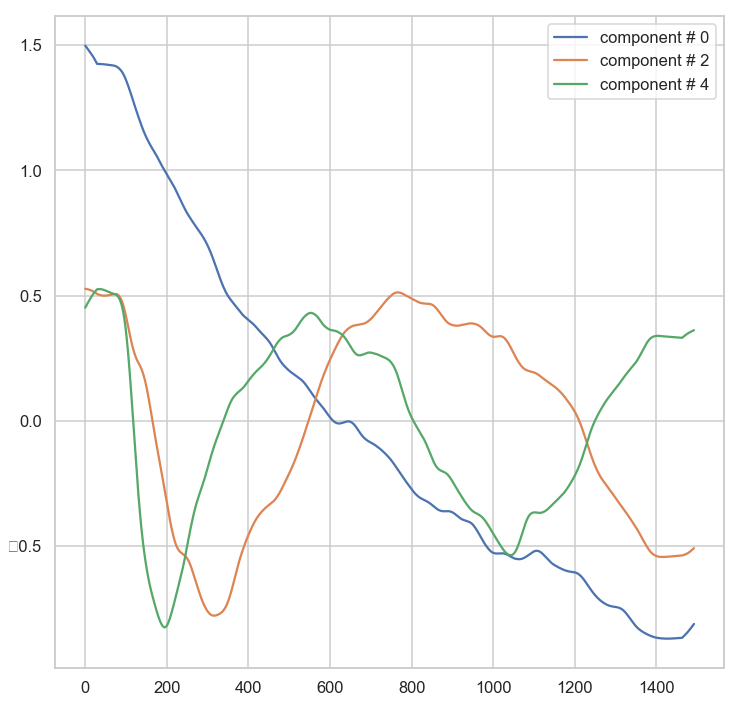

In [18]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[4, :, 0], label='component # 0')
plt.plot(mssa.components_[4, :, 2], label='component # 2')
plt.plot(mssa.components_[4, :, 3], label='component # 4')
plt.legend()
plt.show()

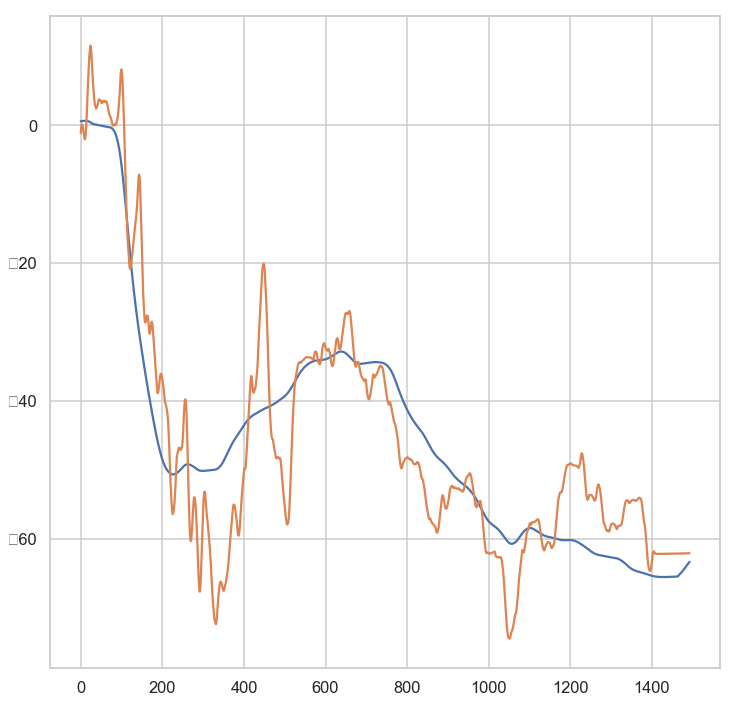

In [19]:
plt.figure(figsize=(12, 12))
plt.plot((mssa.components_[4, :, 0] + mssa.components_[4, :, 2] + mssa.components_[4, :, 3]) * X[:, 4].std() + X[:, 4].mean())
plt.plot(X[:, 4])
plt.show()

## Корреляции собственных компонент

Видны невооружённым взглядом :)

In [20]:
print(mssa.component_ranks_[:5, [2]].ravel(), mssa.component_ranks_[:5, [4]].ravel())

[2 0 4 1 9] [0 2 3 5 4]


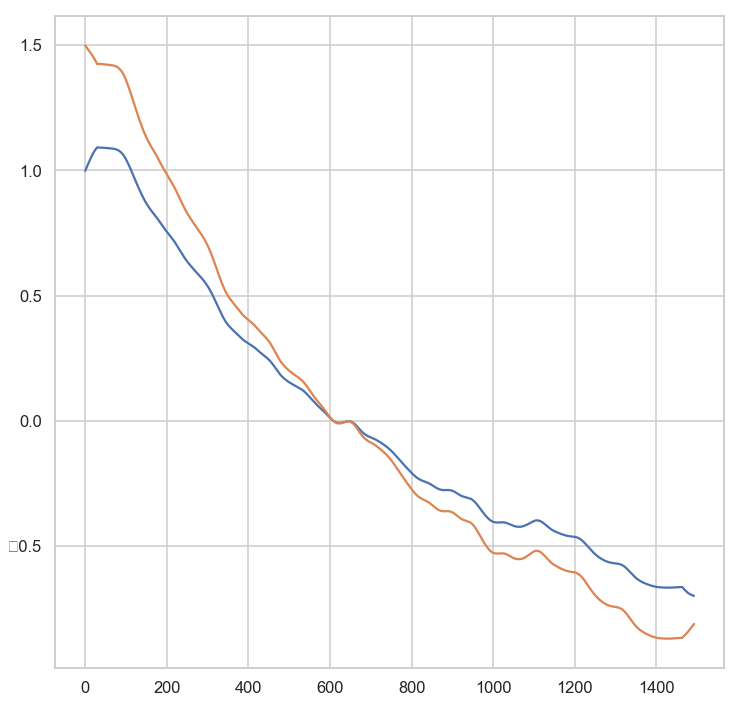

In [21]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[2, :, 0])
plt.plot(mssa.components_[4, :, 0])
plt.show()

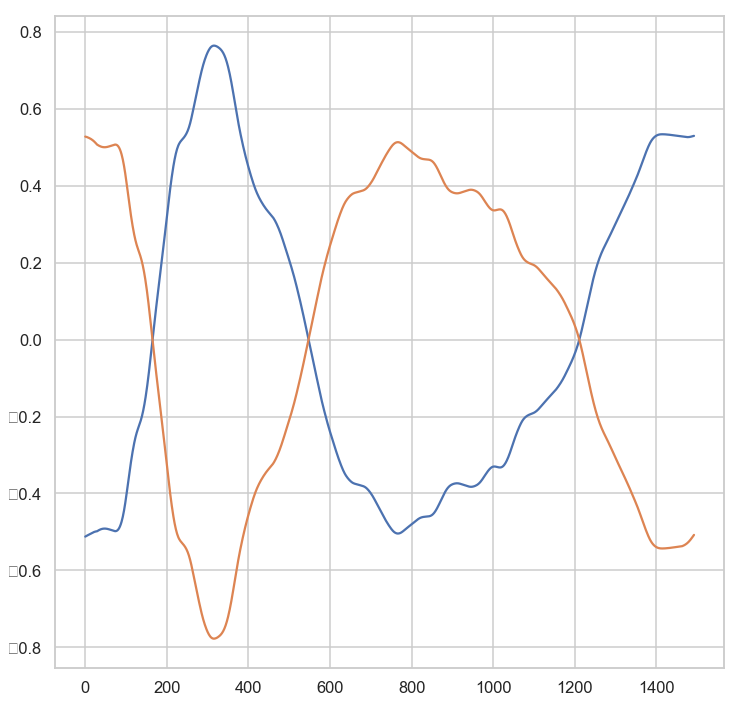

In [22]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[2, :, 2])
plt.plot(mssa.components_[4, :, 2])
plt.show()

## Now let's take a look on two different time series


### Для 6 тайм-серии видны синусовые подпространства, кстати :)

In [23]:
mssa.component_ranks_[:5, [0, 6]]

array([[ 1,  0],
       [ 2,  9],
       [ 6,  8],
       [ 5,  5],
       [10, 10]])

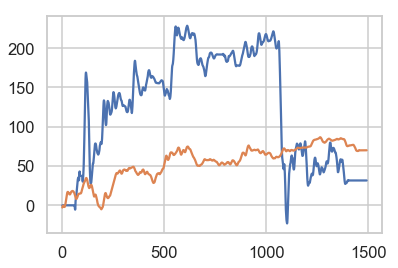

In [24]:
plt.plot(X[:, 0])
plt.plot(X[:, 6])

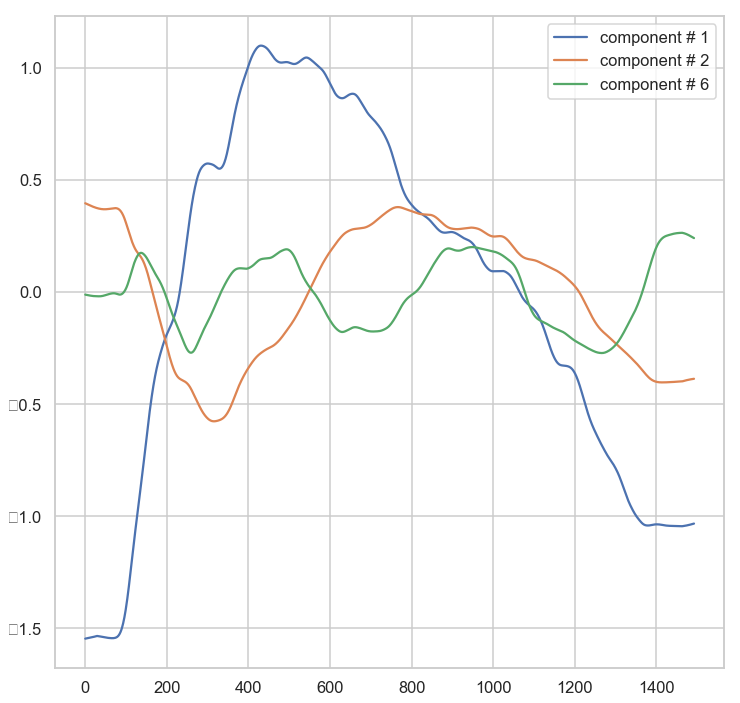

In [25]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[0, :, 1], label='component # 1')
plt.plot(mssa.components_[0, :, 2], label='component # 2')
plt.plot(mssa.components_[0, :, 6], label='component # 6')
plt.legend()
plt.show()

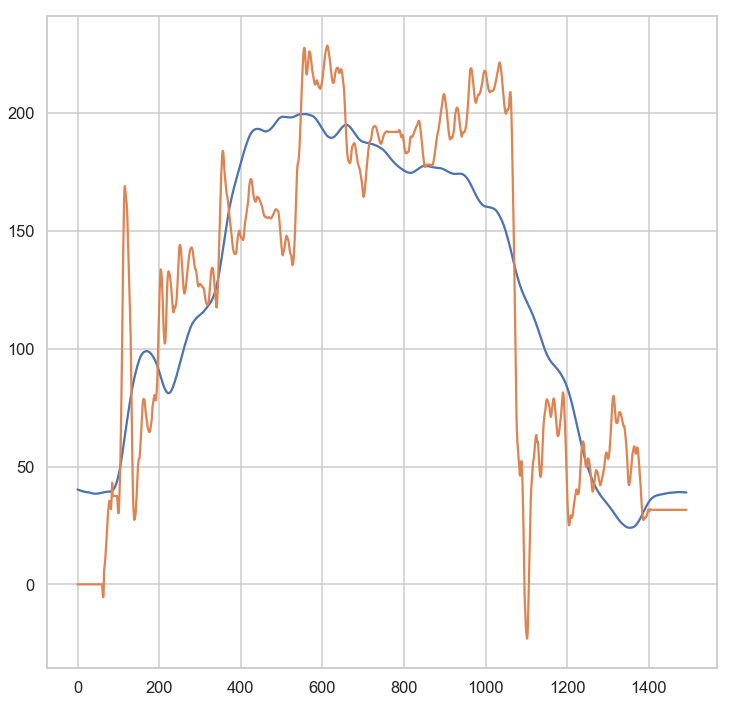

In [26]:
plt.figure(figsize=(12, 12))
plt.plot((mssa.components_[0, :, 1] + mssa.components_[0, :, 2] + mssa.components_[0, :, 6]) * X[:, 0].std() + X[:, 0].mean())
plt.plot(X[:, 0])
plt.show()

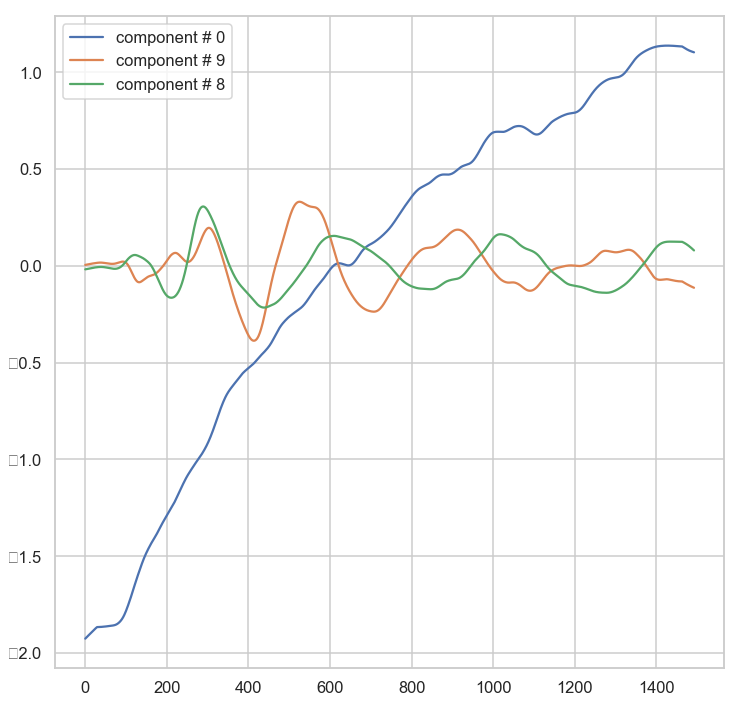

In [27]:
plt.figure(figsize=(12, 12))
plt.plot(mssa.components_[6, :, 0], label='component # 0')
plt.plot(mssa.components_[6, :, 9], label='component # 9')
plt.plot(mssa.components_[6, :, 8], label='component # 8')
plt.legend()
plt.show()

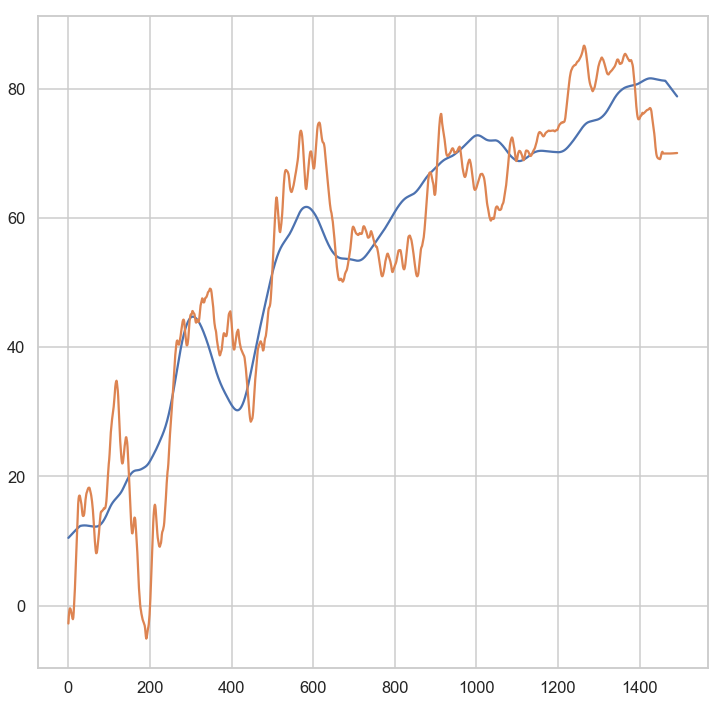

In [28]:
plt.figure(figsize=(12, 12))
plt.plot((mssa.components_[6, :, 0] + mssa.components_[6, :, 9] + mssa.components_[6, :, 8]) * X[:, 6].std() + X[:, 6].mean())
plt.plot(X[:, 6])
plt.show()

## Кластеризация скоррелированных компонент

Вообще говоря, базисные вектора, которые находит SSA, могут быть скоррелированы. Процедура их получения не гарантирует их ортогональности.

Поэтому, первым делом нужно сгруппировать наиболее скоррелированные компоненты.

И, желательно, автоматически.

[[ 1.         -0.02058494]
 [-0.02058494  1.        ]]


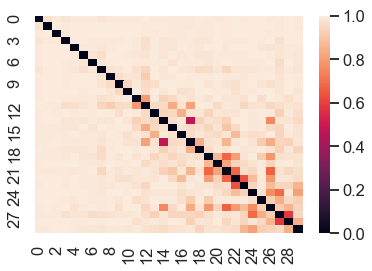

In [29]:
# https://thelonenutblog.wordpress.com/2017/03/30/correlation-matrix-clustering/comment-page-1/
# https://stats.stackexchange.com/questions/165194/using-correlation-as-distance-metric-for-hierarchical-clustering
# https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd
w_correlation = mssa.w_correlation(mssa.components_[0, :])
print(np.corrcoef(mssa.components_[0, :][:, 6], mssa.components_[0, :][:, 2]))
distance_matrix = 1 - np.abs(w_correlation)
# np.fill_diagonal(distance_matrix, val=0)
sns.heatmap(distance_matrix)

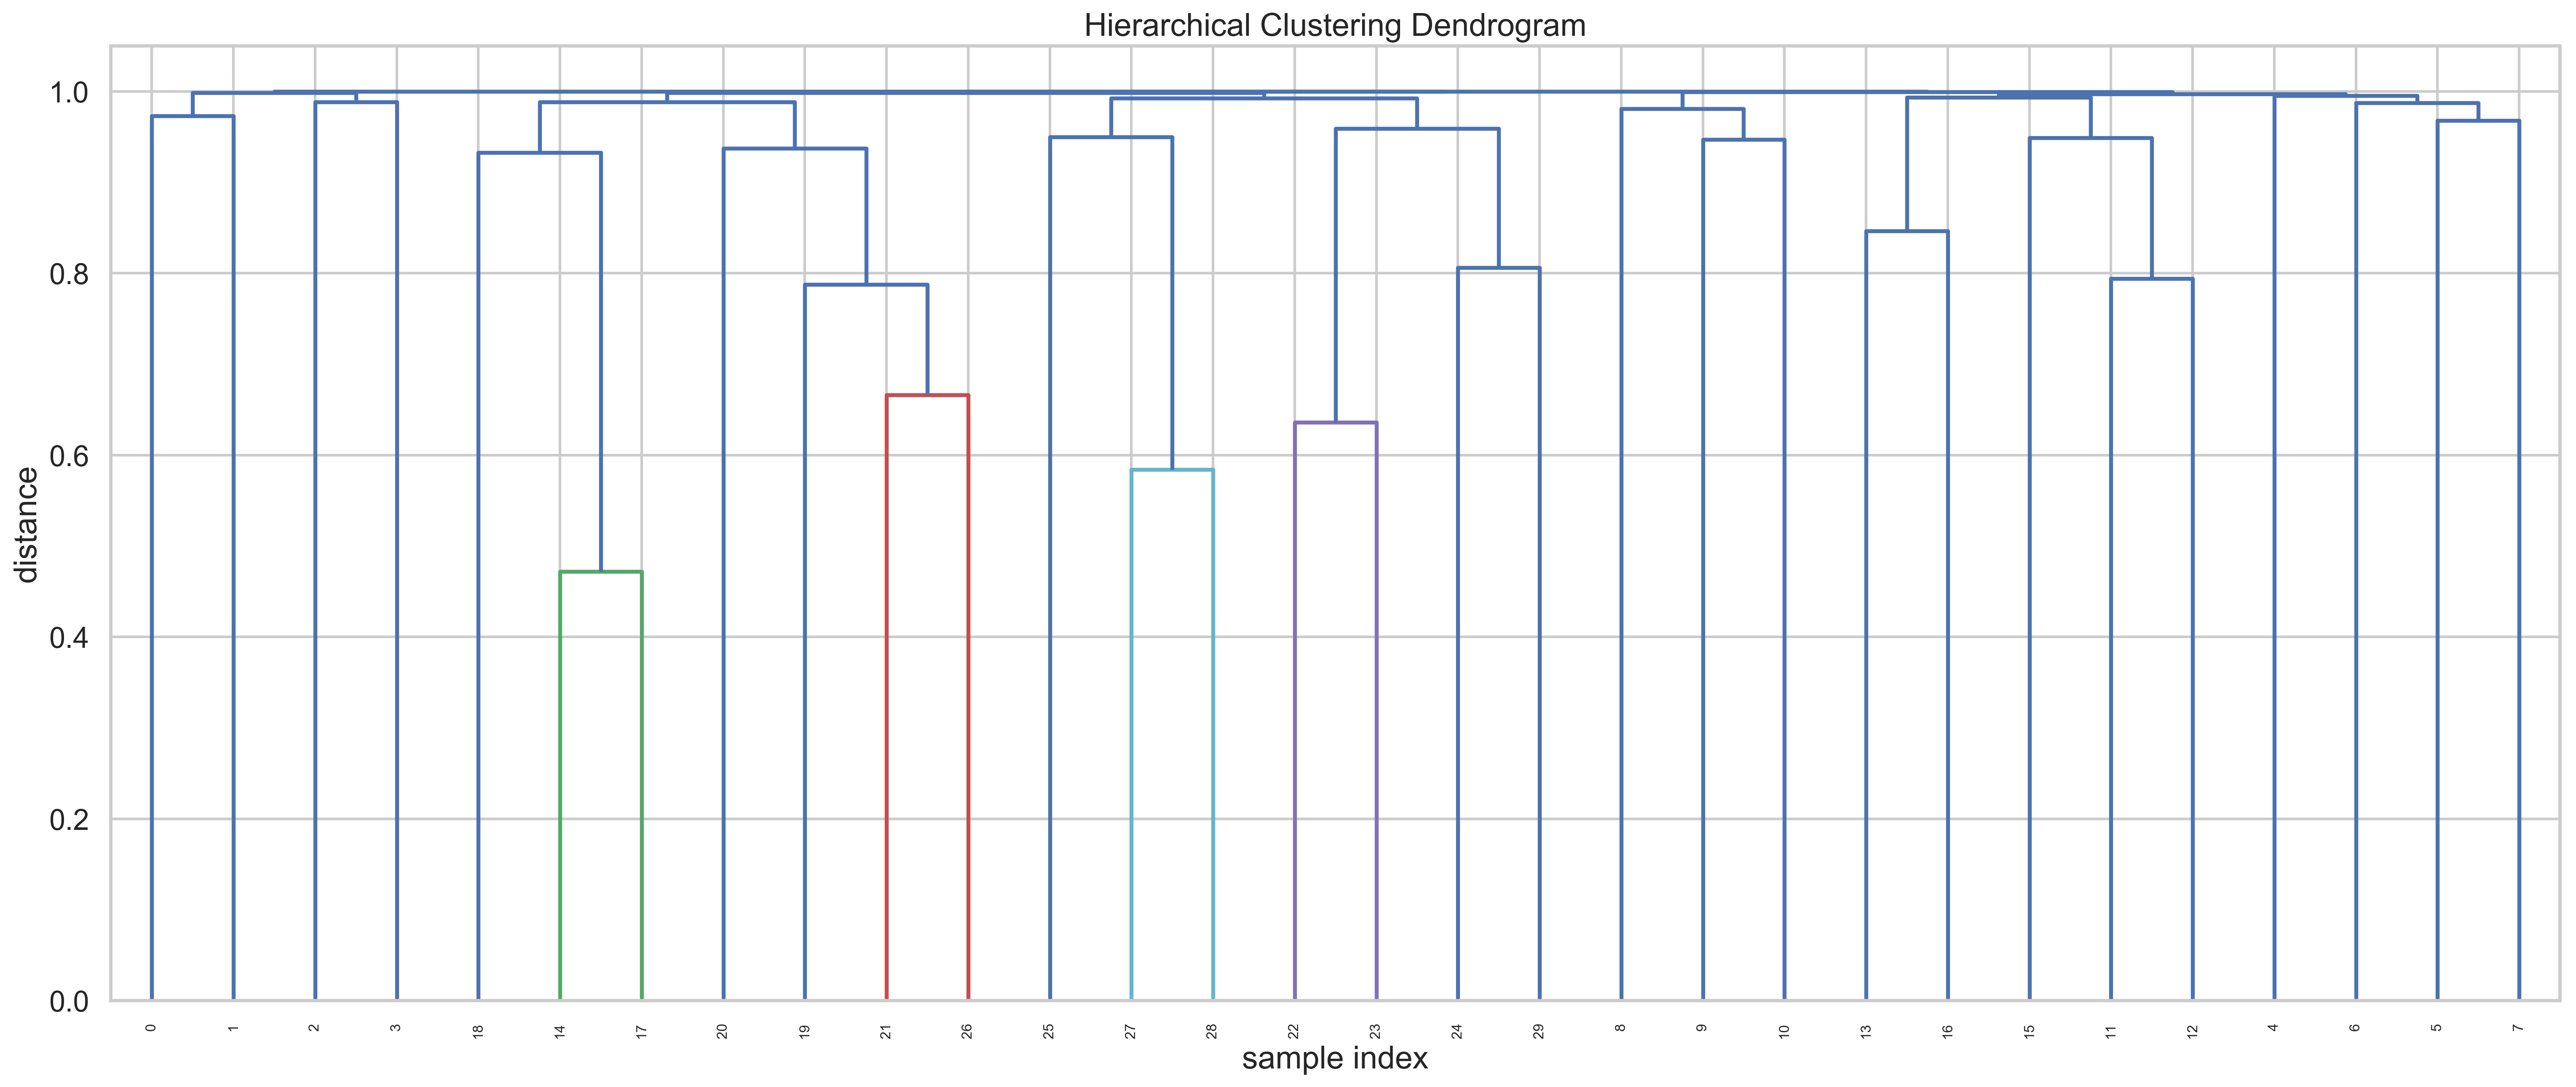

In [30]:
Z = linkage(ssd.squareform(np.abs(distance_matrix)), method='complete')

plt.figure(figsize=(25, 10), dpi=300)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

In [31]:
from scipy.cluster.hierarchy import fcluster
ind = fcluster(Z, 0.95 * distance_matrix.max(), 'distance')

In [32]:
np.unique(ind, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=int32),
 array([1, 1, 1, 1, 3, 4, 3, 2, 2, 2, 1, 2, 3, 1, 1, 1, 1]))

In [33]:
reindex = np.argsort(ind)

In [34]:
reindex

array([ 0,  1,  2,  3, 18, 17, 14, 26, 21, 20, 19, 28, 27, 25, 23, 22, 24,
       29, 10,  9,  8, 13, 16, 15, 12, 11,  5,  7,  6,  4])

In [35]:
from collections import defaultdict

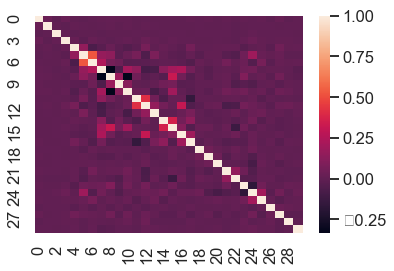

In [36]:
w_correlation = mssa.w_correlation(mssa.components_[0, :][:, reindex])
sns.heatmap(w_correlation)

In [37]:
d = defaultdict(list)
[d[i].append(k) for i, k in zip(ind, reindex)];

In [38]:
print(list(d.values()))

[[0], [1], [2], [3], [18], [17], [14], [26], [21], [20, 19], [28, 27, 22], [25, 24], [23, 29, 10], [9, 8, 13, 5], [16, 15], [12, 4], [11, 7, 6]]


In [39]:
mssa.set_ts_component_groups(timeseries_index=0, groups=list(d.values()))

In [40]:
ts0_grouped = mssa.grouped_components_[0]

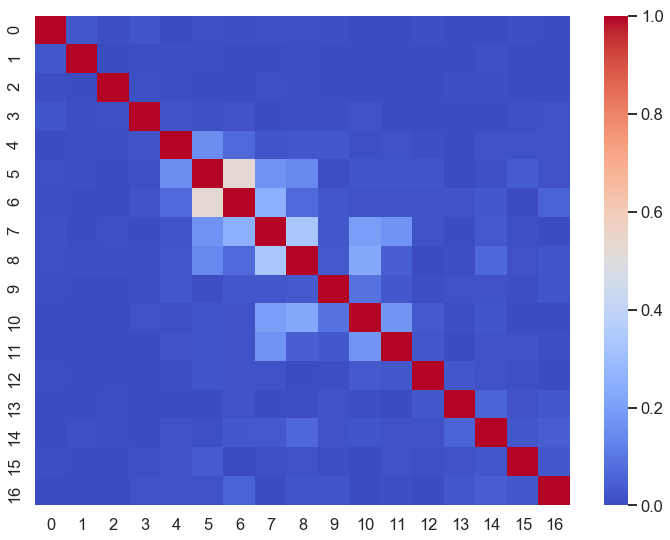

In [41]:
ts0_grouped_wcor = mssa.w_correlation(ts0_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts0_grouped_wcor), cmap='coolwarm', ax=ax)

# skggm

https://skggm.github.io/skggm/tour

skggm позволяет находить, к сожалению, только линейные зависимости.

In [42]:
%%time
from inverse_covariance import QuicGraphLasso
models = []
for X in X_divided:
    model = QuicGraphLasso(lam=0.9)
    model.fit(X)
    models.append(model)

/root/miniconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/root/miniconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class QuicGraphLasso is deprecated; The class QuicGraphLasso is deprecated Use class QuicGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/miniconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class QuicGraphLasso is deprecated; The class QuicGraphLasso is deprecated Use class QuicGraphicalLasso instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/miniconda/lib/pyt

CPU times: user 6.48 s, sys: 12.5 s, total: 19 s
Wall time: 948 ms


In [43]:
precisions = []
for model in models:
    precisions.append(model.precision_)

In [44]:
non_zero_corrs = []
precision_selecteds = []
for precision in precisions:
    non_zero_correlation = np.argwhere((precision != 0))
    non_zero_correlation = non_zero_correlation[non_zero_correlation.std(axis=1) != 0]
    non_zero_correlation = np.unique(np.sort(non_zero_correlation, axis=1), axis=0)
    precision_selected = precision[non_zero_correlation[:, 0], non_zero_correlation[:, 1]]

    sort_order = np.argsort(np.abs(precision_selected))[::-1]
    precision_selected = precision_selected[sort_order]
    non_zero_correlation = non_zero_correlation[sort_order]
    
    precision_selecteds.append(precision_selected)
    non_zero_corrs.append(non_zero_correlation)

In [45]:
non_zero_corrs_sets = []
for non_zero_corr in non_zero_corrs:
    non_zero_corrs_sets.append((set(list(map(tuple, non_zero_corr)))))

In [46]:
from collections import Counter

counter = Counter()

In [47]:
for non_zero_corrs_set in non_zero_corrs_sets:
    counter.update(non_zero_corrs_set)

In [48]:
counter.most_common(50)

[((5, 6), 9),
 ((14, 15), 7),
 ((259, 317), 7),
 ((107, 109), 6),
 ((85, 102), 6),
 ((90, 97), 5),
 ((204, 237), 5),
 ((84, 204), 5),
 ((204, 259), 5),
 ((51, 107), 5),
 ((109, 149), 5),
 ((107, 224), 5),
 ((81, 96), 5),
 ((85, 267), 4),
 ((84, 116), 4),
 ((96, 102), 4),
 ((86, 130), 4),
 ((237, 317), 4),
 ((92, 96), 4),
 ((172, 177), 4),
 ((81, 267), 4),
 ((61, 276), 4),
 ((204, 317), 4),
 ((237, 259), 4),
 ((96, 251), 4),
 ((77, 116), 4),
 ((204, 267), 4),
 ((59, 107), 4),
 ((59, 109), 4),
 ((84, 237), 4),
 ((81, 85), 4),
 ((102, 267), 4),
 ((43, 209), 4),
 ((81, 102), 4),
 ((84, 259), 4),
 ((257, 276), 4),
 ((189, 232), 4),
 ((60, 276), 4),
 ((226, 347), 4),
 ((321, 347), 4),
 ((49, 228), 3),
 ((84, 109), 3),
 ((77, 81), 3),
 ((96, 255), 3),
 ((251, 259), 3),
 ((237, 251), 3),
 ((81, 84), 3),
 ((43, 153), 3),
 ((204, 288), 3),
 ((116, 267), 3)]

5 6


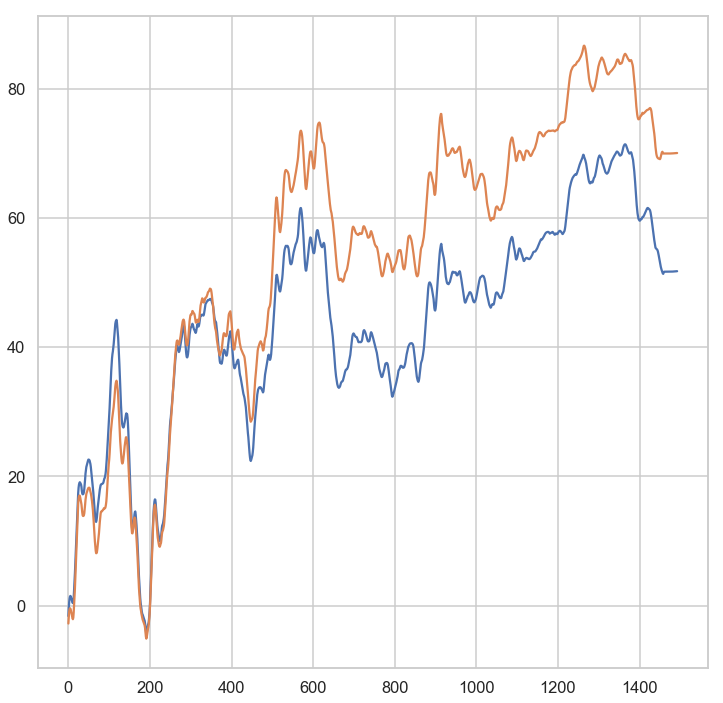

14 15


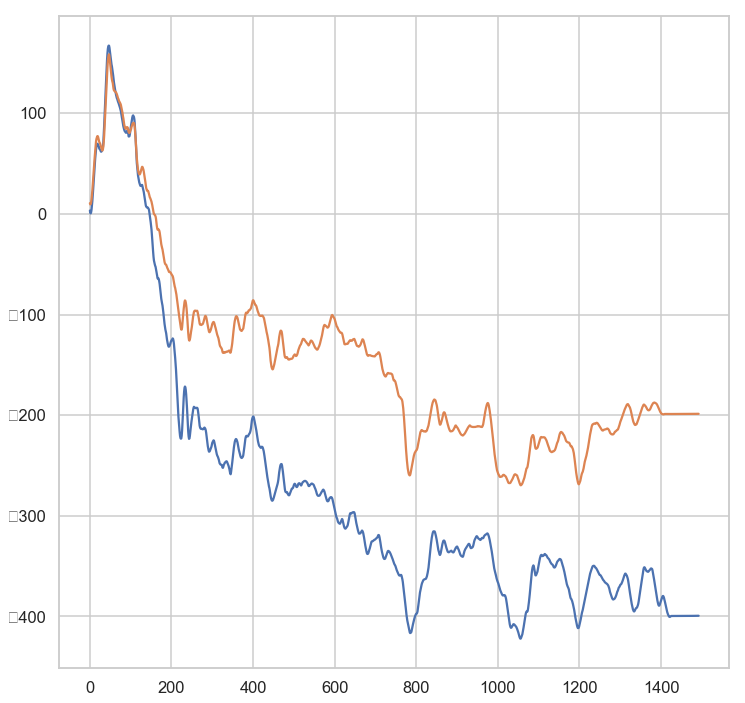

In [49]:
l = 0
for (i, j), k in counter.most_common(2):
    print(i, j)
    plt.figure(figsize=(12, 12))
    plt.plot(X_divided[l][:, i])
    plt.plot(X_divided[l][:, j])
    plt.show()

In [50]:
print(mssa.component_ranks_[:5, [5, 6]])
print(mssa.component_ranks_explained_variance_[:5, [2, 4]])

[[ 0  0]
 [ 9  9]
 [ 4  8]
 [ 5  5]
 [ 8 10]]
[[0.14497069 0.51677295]
 [0.26277735 0.1947945 ]
 [0.23627534 0.14285763]
 [0.21966608 0.03406295]
 [0.01927076 0.00365514]]


In [51]:
print(mssa.component_ranks_[:5, [14, 15]])
print(mssa.component_ranks_explained_variance_[:5, [14, 15]])

[[ 0  0]
 [ 4  3]
 [ 6  5]
 [19 10]
 [ 8 13]]
[[8.50558231e-01 8.20101719e-01]
 [8.05482080e-03 7.75298230e-02]
 [2.08934772e-03 6.49897010e-03]
 [7.94494339e-04 6.84292376e-03]
 [1.24787694e-03 3.05087713e-03]]
